# electrical preprocessing experiments

In [63]:
import numpy as np
from scipy.signal import butter, lfilter, medfilt, savgol_filter, welch, hilbert
from scipy.fft import fft
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
path = "/its/home/drs25/RoboSkin/Code/NewRigExperiments/"
datapath=path+"texture-tactip/"
datapath="/its/home/drs25/datasets/"

## load in dataset

In [2]:
data = np.load(datapath+"X_data_presstip.npz") #load data
X=None
for array_name in data:
    X=data[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data = np.load(datapath+"y_data_presstip.npz") #load data
y=None
for array_name in data:
    y=data[array_name]
print(X.shape,y.shape)

(3000, 20, 16) (3000,)


## preprocess functions

In [28]:
def butterworth_filter(data, cutoff=8, fs=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return np.array([lfilter(b, a, d) for d in data])

def low_pass_filter(data, cutoff=8, fs=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return np.array([lfilter(b, a, d) for d in data])

def median_filter(data, kernel_size=5):
    return np.array([medfilt(d, kernel_size=kernel_size) for d in data])

def savgol_filter_data(data, window_length=11, polyorder=3):
    return np.array([savgol_filter(d, window_length=window_length, polyorder=polyorder) for d in data])

def apply_fft(data):
    return np.abs(fft(data))[:, :data.shape[1] // 2]

def compute_psd(data, fs=50):
    return np.array([welch(d, fs=fs, nperseg=min(64, len(d)))[1] for d in data])

def wavelet_transform(data, wavelet='db4', level=3):
    return np.array([pywt.wavedec(d, wavelet, level=level)[0] for d in data])

def hilbert_transform(data):
    return np.abs(hilbert(data, axis=-1))

/tmp/ipykernel_1680455/3195782269.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="center right", fontsize=7)


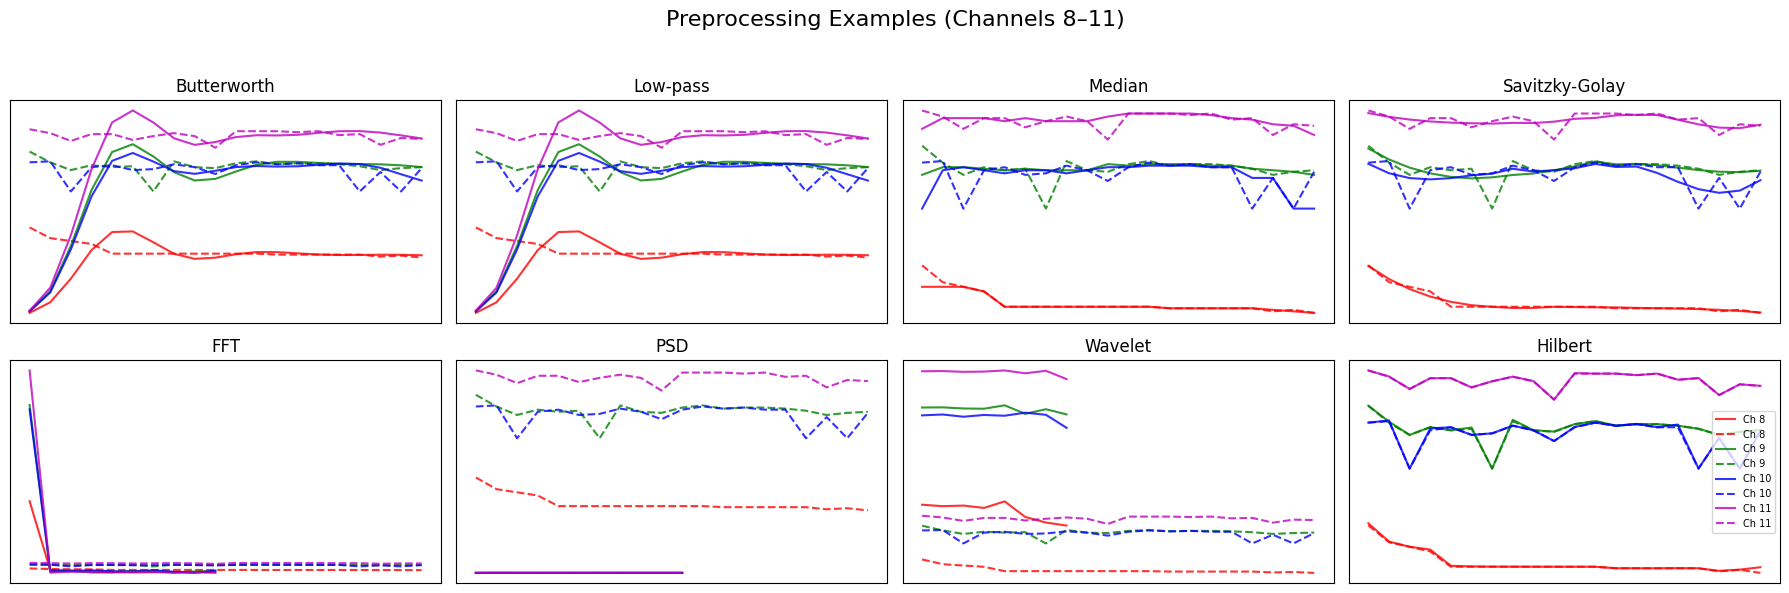

In [50]:
channels=[8,9,10,11]
fs=50
signals = np.array([X[0, :, ch] for ch in channels])  # shape (4, T)
methods = [
    ("Butterworth", butterworth_filter(signals, 8,fs=fs)),
    ("Low-pass", low_pass_filter(signals, 8, fs=fs)),
    ("Median", median_filter(signals)),
    ("Savitzky-Golay", savgol_filter_data(signals)),
    ("FFT", apply_fft(signals)),
    ("PSD", compute_psd(signals, fs=fs)),
    ("Wavelet", wavelet_transform(signals)),
    ("Hilbert", hilbert_transform(signals)),
]

# Plotting: 2x4 layout
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
fig.suptitle('Preprocessing Examples (Channels 8–11)', fontsize=16)
c=["r","g","b","m"]
for ax, (title, processed) in zip(axes.flatten(), methods):
    for i, ch in enumerate(channels):
        ax.plot(processed[i], c=c[i], label=f"Ch {ch}", alpha=0.8)
        ax.plot(signals[i],"--", c=c[i],label=f"Ch {ch}", alpha=0.8)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.legend(loc="center right", fontsize=7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(path+"/images/preprocessing_example.pdf")
plt.show()

In [59]:
#signals = np.array([X[0, :, ch] for ch in channels])  # shape (4, T)
channels=[8,9,10,11]
print(X[i, :, ch].reshape(1,len(X[0])).shape)

"""methods = [[[butterworth_filter(X[i, :, ch].reshape((1,len(X[0]),1)), 8,fs=fs),low_pass_filter(X[i, :, ch].reshape((1,len(X[0]),1)), 8, fs=fs),
    median_filter(X[i, :, ch]),savgol_filter_data(X[i, :, ch].reshape((1,len(X[0])))),
    apply_fft(X[i, :, ch]).reshape((1,len(X[0]),1)),compute_psd(X[i, :, ch], fs=fs).reshape((1,len(X[0]),1)),
    wavelet_transform(X[i, :, ch]).reshape((1,len(X[0]),1)), hilbert_transform(X[i, :, ch] ).reshape((1,len(X[0]),1)),
] for ch in channels] for i in range(len(X))]"""

signals = np.array([[X[i, :, ch] for i in range(len(X))] for ch in channels]).reshape(4*len(X),20)  # shape (4, T)
print(signals.shape)
methods = {
    "Butterworth": butterworth_filter(signals, 8,fs=fs).reshape(4,len(X),20),
    "Low-pass": low_pass_filter(signals, 8, fs=fs).reshape(4,len(X),20),
    "Median": median_filter(signals).reshape(4,len(X),20),
    "Savitzky-Golay": savgol_filter_data(signals).reshape(4,len(X),20),
    "FFT": apply_fft(signals).reshape(4,len(X),-1),
    "PSD": compute_psd(signals, fs=fs).reshape(4,len(X),-1),
    "Wavelet": wavelet_transform(signals).reshape(4,len(X),-1),
    "Hilbert": hilbert_transform(signals).reshape(4,len(X),20),
}


(1, 20)
(12000, 20)


# experiment with models

In [66]:
butterworth_X=methods['Butterworth']

def model_test(dataset):
    train_X, test_X, train_y, test_y = train_test_split(dataset.reshape(len(dataset),-1), y, test_size=0.2, random_state=np.random.randint(0,100))
    clf = RandomForestClassifier(max_depth=50, random_state=0)
    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    y_pred2 = clf.predict(train_X)

    loss=np.abs(y_pred-test_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    print("Test Accuracy:",correct/len(loss))
    tt=correct/len(loss)
    loss=np.abs(y_pred2-train_y)
    loss[loss>0]=1
    correct=len(loss)-np.sum(loss)
    print("Train Accuracy:",correct/len(loss))
    return tt, correct/len(loss)

print(butterworth_X.shape)
model_test(butterworth_X[0])

(4, 3000, 20)
Test Accuracy: 0.785
Train Accuracy: 1.0


(0.785, 1.0)